In [10]:
### import all used libraries

from sklearn.metrics.pairwise import polynomial_kernel,rbf_kernel,sigmoid_kernel
from sklearn.metrics.pairwise import additive_chi2_kernel,chi2_kernel,cosine_similarity
from sklearn.metrics.pairwise import cosine_distances,euclidean_distances,laplacian_kernel
from sklearn.metrics.pairwise import polynomial_kernel,manhattan_distances
import numpy as np
import glob
import pickle as pk
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PolynomialFeatures
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [5]:
### creates a dictionary for the divisions

# define the paths into the container
data_path  = 'data/prob-reductions/*'

# create a list of config files

file_list  = glob.glob(data_path)

# creating data divisions dictionary

divisions_dict = {}

# getting number of divisions

n_elements = len(file_list)

print('Reading reductions...')

for i,file_name in enumerate(file_list):

    with open(file_name, 'rb') as f:
        seed = pk.load(f)

    divisions_dict[i] = seed

    # updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()


Reading reductions...
[----------------------------------------------------------------------------------------------------] 100.00% - 1 of 1

In [12]:
### definig set of parameters to study

# defining attributes to use

#att_list = [3,10,14,15,16,17,18]

att_list = [18]

# defining list of metrics

metrics = [
    additive_chi2_kernel,
    chi2_kernel,
    laplacian_kernel,
    polynomial_kernel,
    polynomial_kernel,
    polynomial_kernel,
    rbf_kernel,
    sigmoid_kernel,
]

names = [
    'additive chi-squared',
    'exponential chi-squared',
    'laplacian kernel',
    'polynomial kernel 2nd degree',
    'polynomial kernel 3nd degree',
    'polynomial kernel 4nd degree',
    'rbf (gaussian) kernel',
    'sigmoid'
]

degrees = [
    0,
    0,
    0,
    2,
    3,
    4,
    0,
    0,
]


In [78]:
### definig set of parameters to study

# defining attributes to use

#att_list = [3,10,14,15,16,17,18]

att_list = [18]

# defining list of metrics

#metrics = [
#    additive_chi2_kernel,
#    chi2_kernel,
    cosine_similarity,
    cosine_distances,
    euclidean_distances,
#    haversine_distances,
    laplacian_kernel,
    manhattan_distances,
    polynomial_kernel,
    rbf_kernel,
    sigmoid_kernel,
]

names = [
    'additive chi-squared',
    'exponential chi-squared',
    'cosine similarity',
    'cosine distance',
    'Euclidean distance',
#    'Haversine distance',
    'laplacian kernel',
    'L1 distance',
    'polynomial kernel',
    'rbf (gaussian) kernel',
    'sigmoid'

]

In [14]:
### calculing pairrwise metrics

metrics_dict = {}


for reduction in divisions_dict:

    # Reading data and label

    data = divisions_dict[reduction]['df'].values

    data = data[:,att_list]

    y = divisions_dict[reduction]['labels']


    # Separrating signal from background

    background = data[y==0]
    
    signal = data[y==1]


    ### computing pairwise metrrics

    metrics_dict[reduction] = {}

    # getting number of divisions

    n_elements = len(data)*len(metrics)

    k = 0


    print('Calculating pairwise metrics...')

    for name,metric,degree in zip(names,metrics,degrees):

        metrics_dict[reduction][name] = {
            'pairwise_score' : {
                'general' : {
                    'cumulative_prox' : []
                },
                'signal_signal' : {
                    'cumulative_prox' : [],
                    'mean_prox' : [],
                    'std_prox' : []
                },
                'signal_background' : {
                    'cumulative_prox' : [],
                    'mean_prox' : [],
                    'std_prox' : []
                }
            }
        }


        for i in range(len(data)):


            # Calculates the metric for all samples

            line = data[i].reshape(1, -1)

            # inserting polynomial degrees

            if metric == polynomial_kernel:
            
                score = metric(line,data[:],degree=degree)

            else:

                score = metric(line,data[:])


            # compute the distance sum, mean and std between background and signal samples

            dist_sum = np.sum(score**2)


            # concatenating results

            metrics_dict[reduction][name]['pairwise_score']['general']['cumulative_prox'].append(dist_sum)

            if i < 500:

                # Calculates signal-signal metrics

                line = signal[i].reshape(1, -1)
                
                score = metric(line,signal[:])
            

                # compute the distance sum, mean and std between background and signal samples

                dist_sum = np.sum(score**2)

                dsit_mean = np.mean((score**2)**0.5)

                dsit_std = np.std((score**2)**0.5)


                # concatenating results

                metrics_dict[reduction][name]['pairwise_score']['signal_signal']['cumulative_prox'].append(dist_sum)

                metrics_dict[reduction][name]['pairwise_score']['signal_signal']['mean_prox'].append(dsit_mean)

                metrics_dict[reduction][name]['pairwise_score']['signal_signal']['std_prox'].append(dsit_std)


                # Calculates signal-background metrics

                line = signal[i].reshape(1, -1)
                
                score = metric(line,background[:])


                # compute the distance sum, mean and std between background and signal samples

                dist_sum = np.sum(score**2)
                
                dsit_mean = np.mean(((score)**2)**0.5)

                dsit_std = np.std(((score)**2)**0.5)


                # concatenating results

                metrics_dict[reduction][name]['pairwise_score']['signal_background']['cumulative_prox'].append(dist_sum)

                metrics_dict[reduction][name]['pairwise_score']['signal_background']['mean_prox'].append(dsit_mean)

                metrics_dict[reduction][name]['pairwise_score']['signal_background']['std_prox'].append(dsit_std)


            # updating progress bar

            k += 1

            percent = (k)/n_elements * 100/2

            info = '{:.2f}% - {:d} of {:d}'.format(percent*2,(k),n_elements)

            formated_bar = '-'*int(percent) + ' '*int(50-percent)

            if i < (n_elements):

                sys.stdout.write("\r")

            sys.stdout.write('[%s] %s' % (formated_bar,info))

            sys.stdout.flush()
        
    sys.stdout.write("\r")

    print('Calculation complete!\n')


Calculating pairwise metrics...
Calculation complete!



In [15]:
### normalizing metrics

scaler =  MinMaxScaler()

# defining number of iterations

n_it = 0

for redu in metrics_dict:
    
    for metric in metrics_dict[redu]:

        for subset in metrics_dict[redu][metric]['pairwise_score']:

            for result in metrics_dict[redu][metric]['pairwise_score'][subset]:

                data = np.array(metrics_dict[redu][metric]['pairwise_score'][subset][result])

                data = scaler.fit_transform(data.reshape(-1, 1))

                metrics_dict[redu][metric]['pairwise_score'][subset][result]

                n_it += 1


In [16]:
### calculating densities

k = 0

print('Calculating densities...')

for redu in metrics_dict:
    
    for metric in metrics_dict[redu]:

        metrics_dict[redu][metric]['local_density'] = {}
        
        for subset in metrics_dict[redu][metric]['pairwise_score']:

            metrics_dict[redu][metric]['local_density'][subset] = []

            culm_prox = metrics_dict[redu][metric]['pairwise_score'][subset]['cumulative_prox']

            n_elements = len(data)

            total = len(culm_prox)*n_it

            for i in range(len(culm_prox)):

                # calculating general density

                sample = culm_prox[i]

                local_density = np.sum(culm_prox)/(2*n_it*sample)

                metrics_dict[redu][metric]['local_density'][subset].append(local_density)

                # updating progress bar

                k += 1

                percent = (k)/total * 100/2

                info = '{:.2f}% - {:d} of {:d}'.format(percent*2,(k),total)

                formated_bar = '-'*int(percent) + ' '*int(50-percent)

                if i < (total):

                    sys.stdout.write("\r")

                sys.stdout.write('[%s] %s' % (formated_bar,info))

                sys.stdout.flush()
    
    sys.stdout.write("\r")
    print('Calculation complete!\n')


Calculating densities...
Calculation complete!



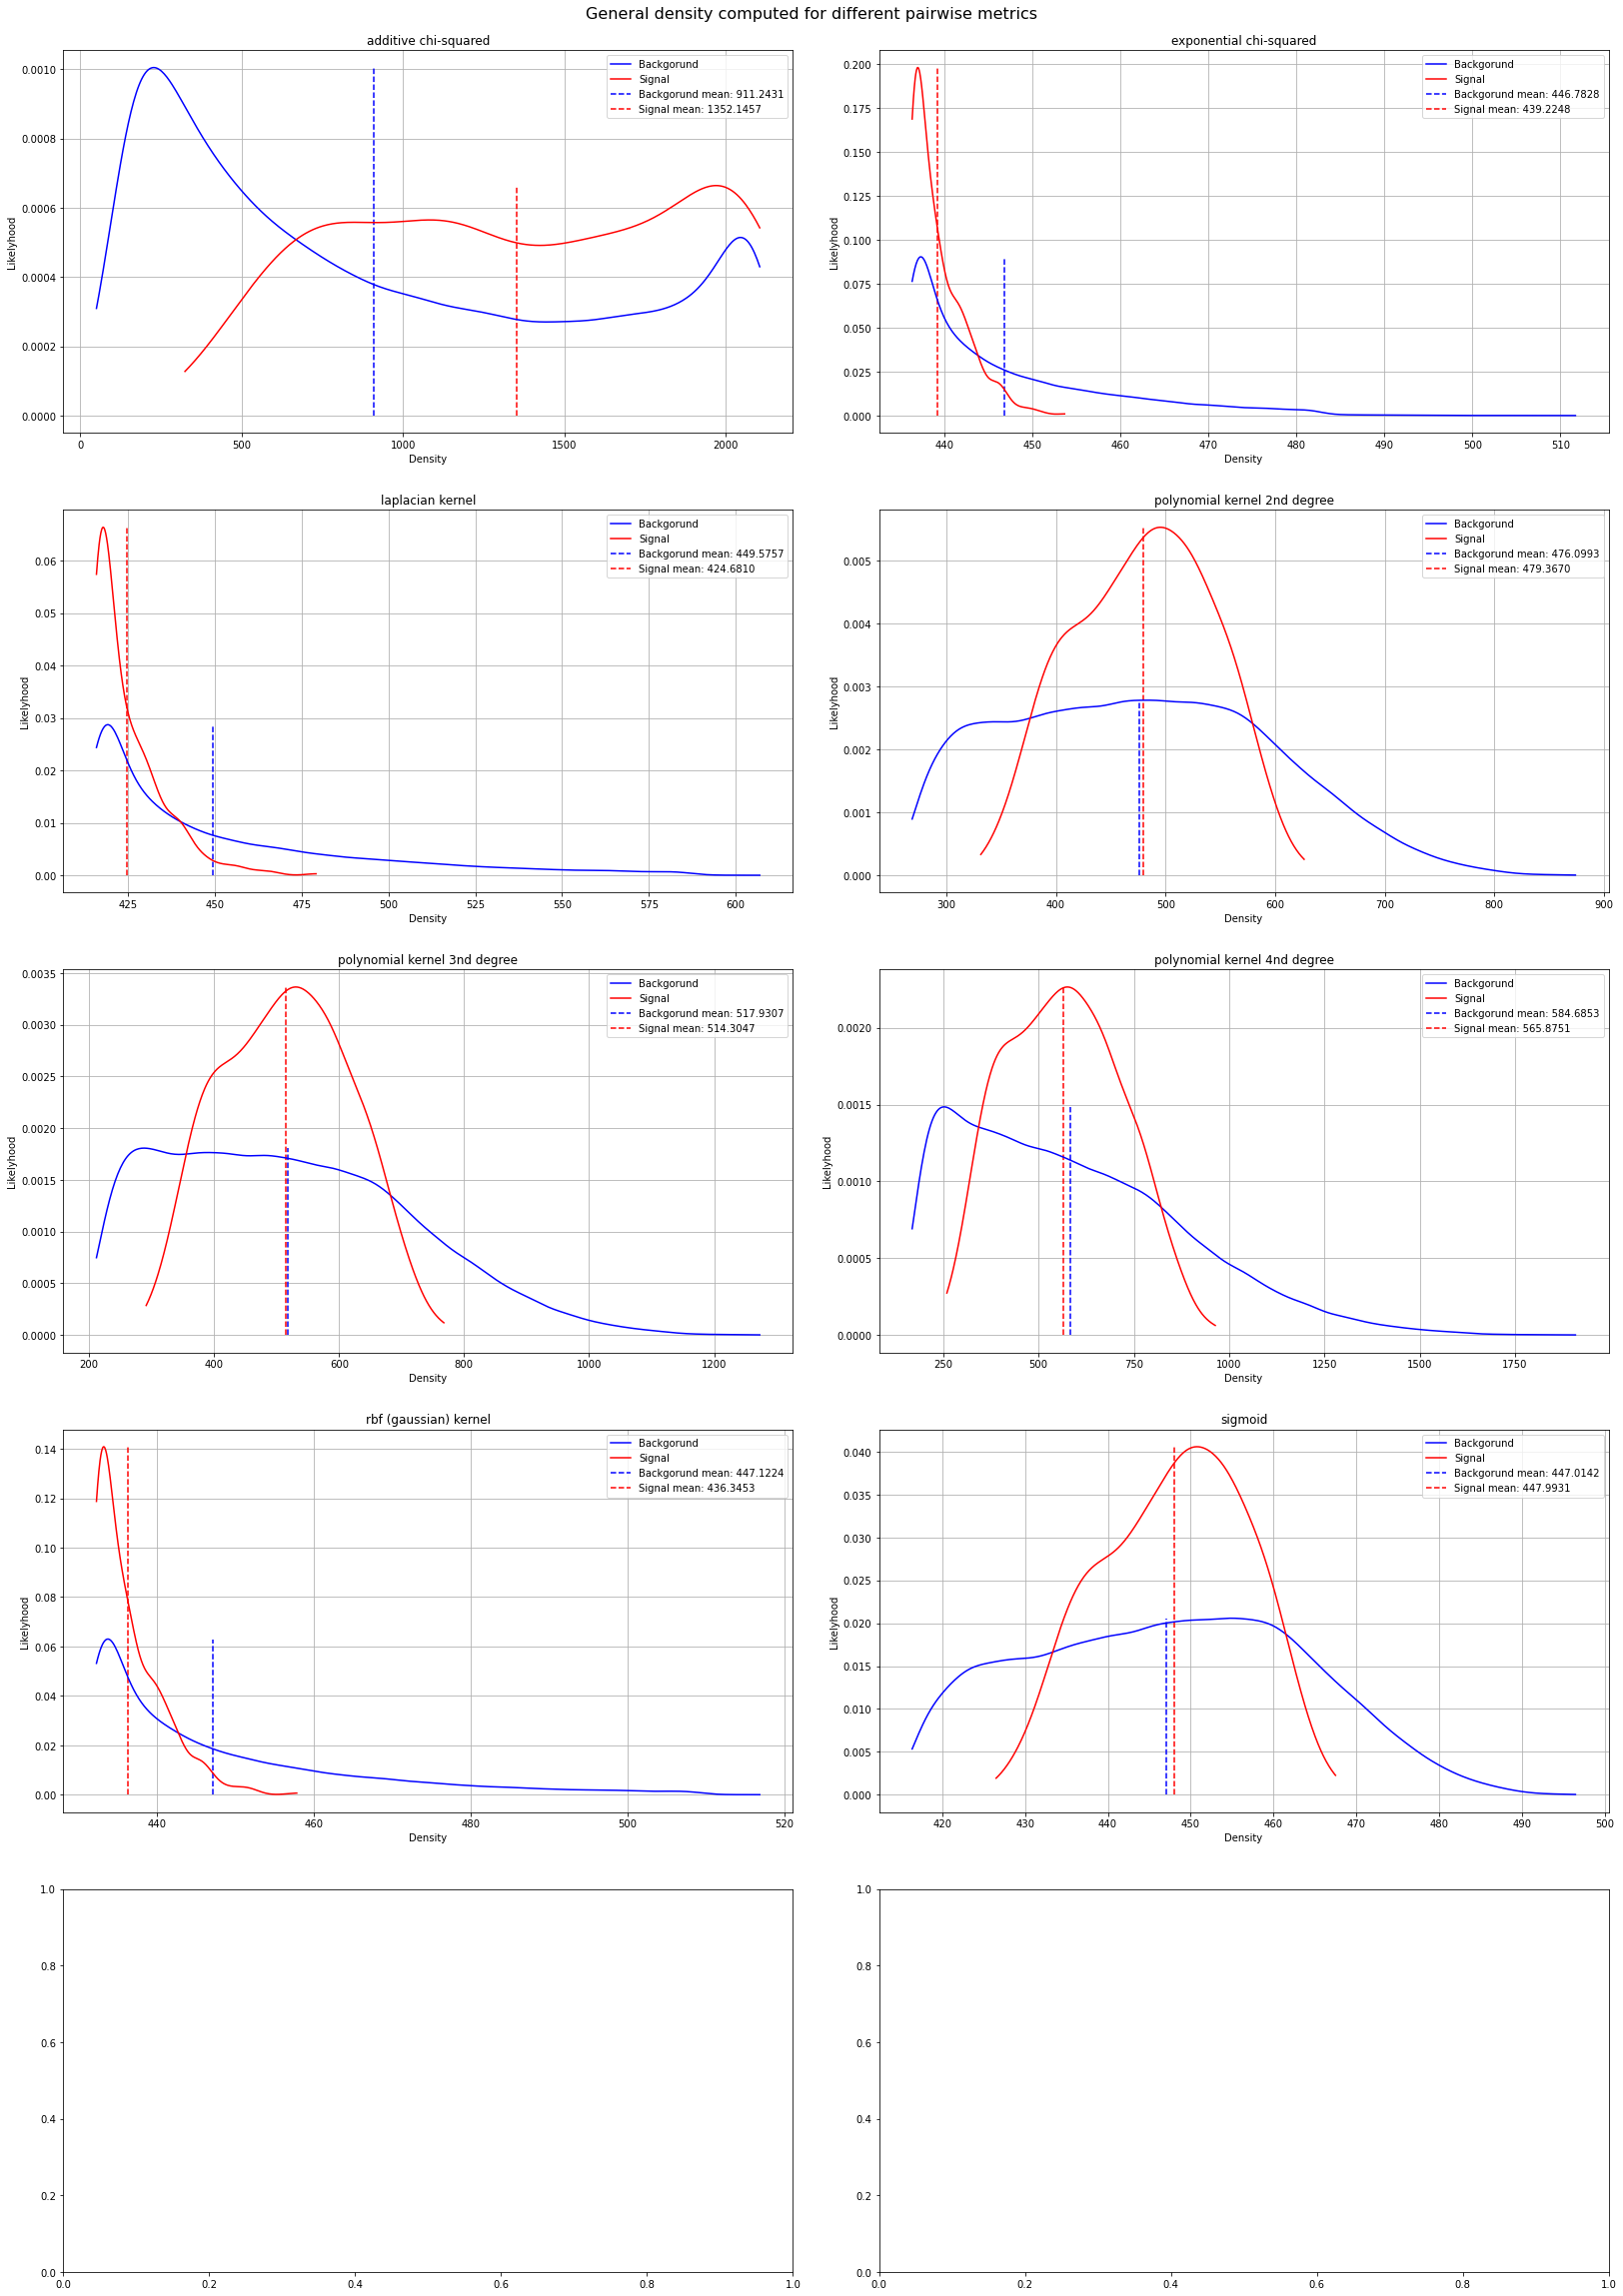

In [17]:
### plot General densities

size_scaler = 8

fig = plt.figure(figsize= (2.9 * size_scaler, 4.1 * size_scaler))

ax = fig.subplots(5,2)

fig.suptitle('General density computed for different pairwise metrics', fontsize=16)

# defining labels

y = divisions_dict[0]['labels']

for i,metric in enumerate(metrics_dict[0]):

        # getting attributes values

        local_density = np.array(metrics_dict[0][metric]['local_density']['general'])

        bg_local_density = local_density[y==0]

        sg_local_density = local_density[y==1]

        # computing the attribute distribution

        bg_kernel = stats.gaussian_kde(bg_local_density)

        sg_kernel = stats.gaussian_kde(sg_local_density)

        # defining attributes limits

        bg_max = max(bg_local_density)

        bg_mean = np.mean(bg_local_density)

        bg_min = min(bg_local_density)

        sg_max = max(sg_local_density)

        sg_mean = np.mean(sg_local_density)

        sg_min = min(sg_local_density)


        # creating values interval for time optimization

        bg_eval = np.linspace(bg_min,bg_max,num=500)

        sg_eval = np.linspace(sg_min,sg_max,num=500)


        # calculating the likelyhood with kde kernel

        bg_likelyhood = bg_kernel(bg_eval)

        sg_likelyhood = sg_kernel(sg_eval)


        # defining mean lines limits

        bg_lk_max = max(bg_likelyhood)

        sg_lk_max = max(sg_likelyhood)


        # defining plot locationg

        line = int(i//2)

        col = int(i%2)


        # ploting results

        ax[line,col].plot(bg_eval, bg_likelyhood, 
                ms=3.5, linestyle='-',color='b',
                label= 'Backgorund')

        ax[line,col].vlines(bg_mean, 0, bg_lk_max,
                linestyle='--',color='b',
                label= 'Backgorund mean: {:.4f}'.format(bg_mean))

        ax[line,col].plot(sg_eval, sg_likelyhood, 
                ms=3.5, linestyle='-',color='r',
                label= 'Signal')

        ax[line,col].vlines(sg_mean, 0, sg_lk_max,
                linestyle='--',color='r',
                label= 'Signal mean: {:.4f}'.format(sg_mean))

        ax[line,col].legend()
        ax[line,col].set_title(metric)
        ax[line,col].set_xlabel('Density')
        ax[line,col].set_ylabel("Likelyhood")
        ax[line,col].grid()

fig.tight_layout(pad=3.0)

plt.savefig('figures/18-attributes-PDF-general-density-most-prob.pdf',format='pdf')

plt.show()

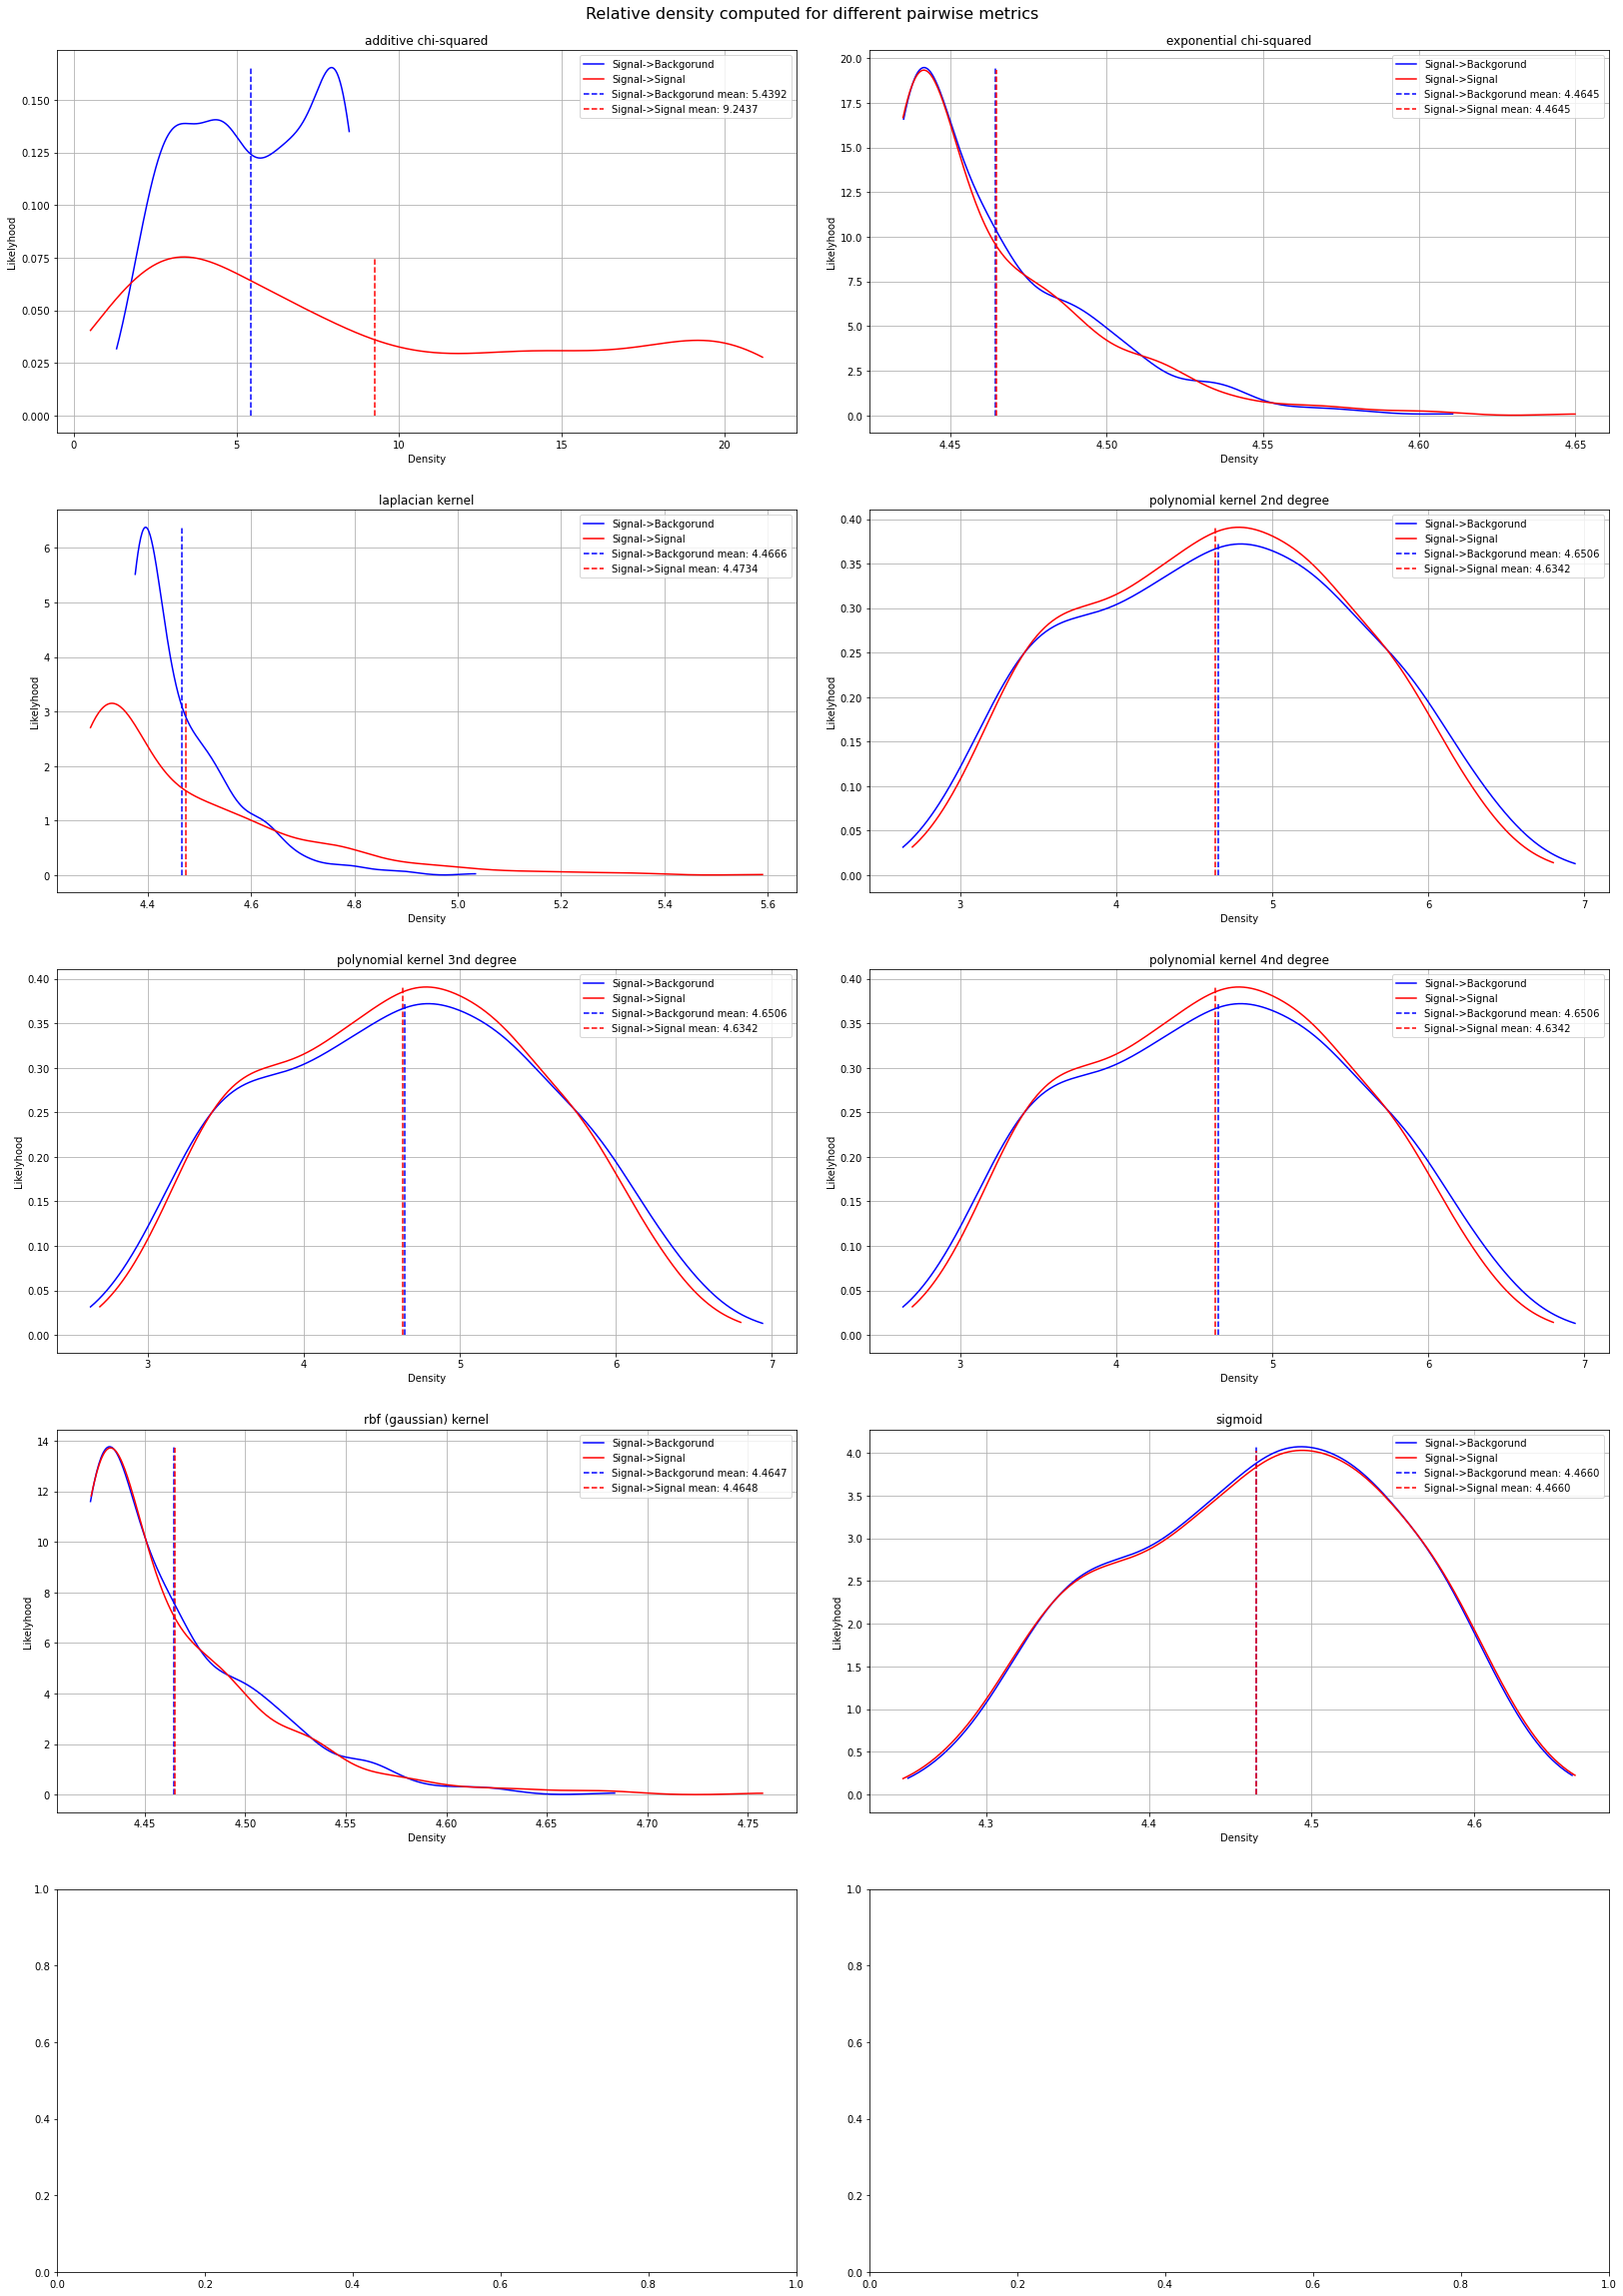

In [18]:
### plot Relative densities

size_scaler = 8

fig = plt.figure(figsize= (2.9 * size_scaler, 4.1 * size_scaler))

ax = fig.subplots(5,2)

fig.suptitle('Relative density computed for different pairwise metrics', fontsize=16)

# defining labels

y = divisions_dict[0]['labels']

for i,metric in enumerate(metrics_dict[0]):

        # getting attributes values

        sg_local_density = np.array(metrics_dict[0][metric]['local_density']['signal_signal'])

        bg_local_density = np.array(metrics_dict[0][metric]['local_density']['signal_background'])


        # computing the attribute distribution

        bg_kernel = stats.gaussian_kde(bg_local_density)

        sg_kernel = stats.gaussian_kde(sg_local_density)


        # defining attributes limits

        bg_max = max(bg_local_density)

        bg_mean = np.mean(bg_local_density)

        bg_min = min(bg_local_density)

        sg_max = max(sg_local_density)

        sg_mean = np.mean(sg_local_density)

        sg_min = min(sg_local_density)


        # creating values interval for time optimization

        bg_eval = np.linspace(bg_min,bg_max,num=500)

        sg_eval = np.linspace(sg_min,sg_max,num=500)


        # calculating the likelyhood with kde kernel

        bg_likelyhood = bg_kernel(bg_eval)

        sg_likelyhood = sg_kernel(sg_eval)


        # defining mean lines limits

        bg_lk_max = max(bg_likelyhood)

        sg_lk_max = max(sg_likelyhood)


        # defining plot locationg

        line = int(i//2)

        col = int(i%2)


        # ploting results

        ax[line,col].plot(bg_eval, bg_likelyhood, 
                ms=3.5, linestyle='-',color='b',
                label= 'Signal->Backgorund')

        ax[line,col].vlines(bg_mean, 0, bg_lk_max,
                linestyle='--',color='b',
                label= 'Signal->Backgorund mean: {:.4f}'.format(bg_mean))

        ax[line,col].plot(sg_eval, sg_likelyhood, 
                ms=3.5, linestyle='-',color='r',
                label= 'Signal->Signal')

        ax[line,col].vlines(sg_mean, 0, sg_lk_max,
                linestyle='--',color='r',
                label= 'Signal->Signal mean: {:.4f}'.format(sg_mean))

        ax[line,col].legend()
        ax[line,col].set_title(metric)
        ax[line,col].set_xlabel('Density')
        ax[line,col].set_ylabel("Likelyhood")
        ax[line,col].grid()

fig.tight_layout(pad=3.0)

plt.savefig('figures/18-attributes-PDF-relative-density-most-prob.pdf',format='pdf')

plt.show()

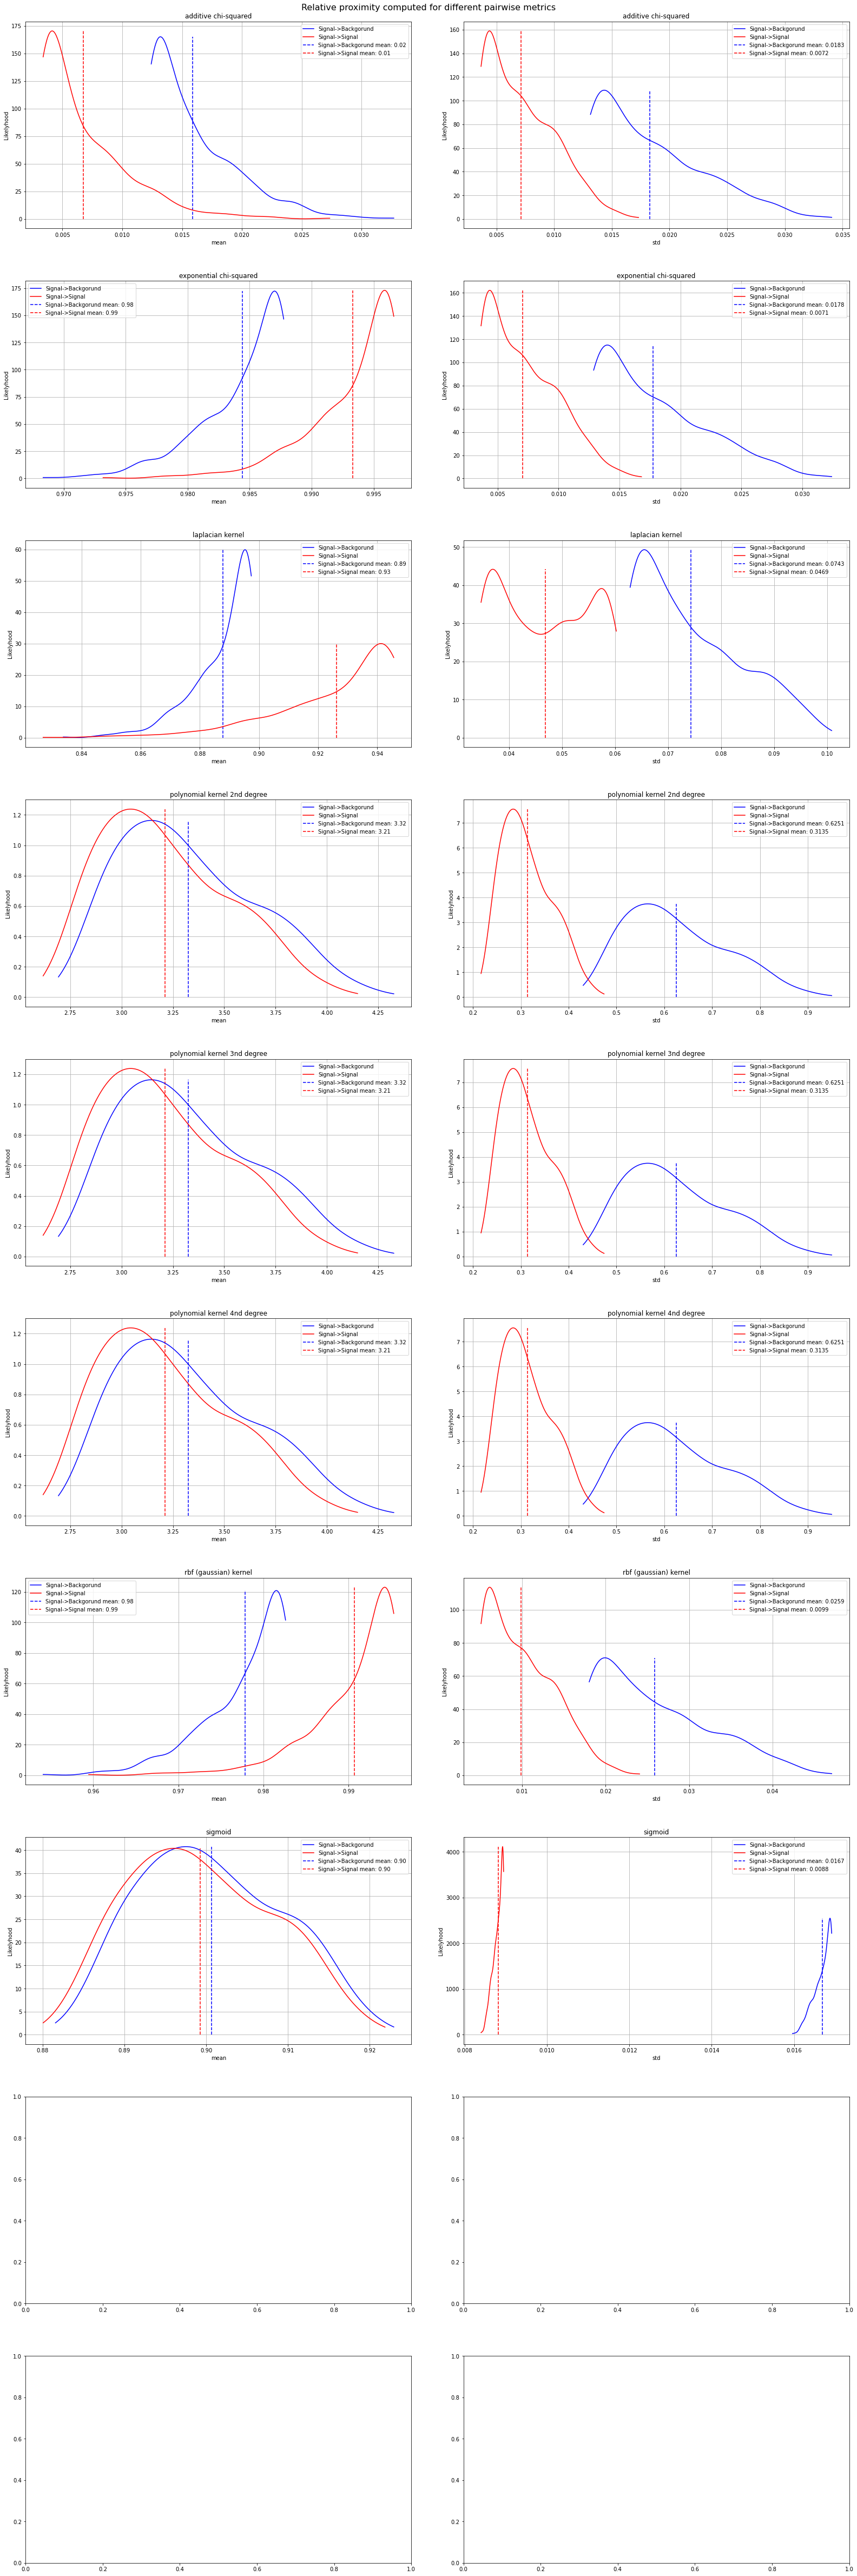

In [19]:
### plot Relative proximity

size_scaler = 8

fig = plt.figure(figsize= (2.9 * size_scaler, 8.5 * size_scaler))

ax = fig.subplots(10,2)

fig.suptitle('Relative proximity computed for different pairwise metrics', fontsize=16)

# defining labels

y = divisions_dict[0]['labels']

for i,metric in enumerate(metrics_dict[0]):

        # getting attributes values

        sg_local_density_mean = np.array(metrics_dict[0][metric]['pairwise_score']['signal_signal']['mean_prox'])

        sg_local_density_std = np.array(metrics_dict[0][metric]['pairwise_score']['signal_signal']['std_prox'])

        bg_local_density_mean = np.array(metrics_dict[0][metric]['pairwise_score']['signal_background']['mean_prox'])

        bg_local_density_std = np.array(metrics_dict[0][metric]['pairwise_score']['signal_background']['std_prox'])


        # computing the attribute distribution

        bg_kernel_mean = stats.gaussian_kde(bg_local_density_mean)

        bg_kernel_std = stats.gaussian_kde(bg_local_density_std)

        sg_kernel_mean = stats.gaussian_kde(sg_local_density_mean)

        sg_kernel_std = stats.gaussian_kde(sg_local_density_std)


        # defining attributes limits

        bg_max_mean = max(bg_local_density_mean)

        bg_mean_mean = np.mean(bg_local_density_mean)

        bg_min_mean = min(bg_local_density_mean)


        bg_max_std = max(bg_local_density_std)

        bg_mean_std = np.mean(bg_local_density_std)

        bg_min_std = min(bg_local_density_std)
        

        sg_max_mean = max(sg_local_density_mean)

        sg_mean_mean = np.mean(sg_local_density_mean)

        sg_min_mean = min(sg_local_density_mean)


        sg_max_std = max(sg_local_density_std)

        sg_mean_std = np.mean(sg_local_density_std)

        sg_min_std = min(sg_local_density_std)


        # creating values interval for time optimization

        bg_eval_mean = np.linspace(bg_min_mean,bg_max_mean,num=500)

        bg_eval_std = np.linspace(bg_min_std,bg_max_std,num=500)

        sg_eval_mean = np.linspace(sg_min_mean,sg_max_mean,num=500)

        sg_eval_std = np.linspace(sg_min_std,sg_max_std,num=500)

        # calculating the likelyhood with kde kernel

        bg_likelyhood_mean = bg_kernel_mean(bg_eval_mean)

        bg_likelyhood_std = bg_kernel_std(bg_eval_std)

        sg_likelyhood_mean = sg_kernel_mean(sg_eval_mean)

        sg_likelyhood_std = sg_kernel_std(sg_eval_std)


        # defining mean lines limits

        bg_lk_max_mean = max(bg_likelyhood_mean)

        bg_lk_max_std = max(bg_likelyhood_std)

        sg_lk_max_mean = max(sg_likelyhood_mean)

        sg_lk_max_std = max(sg_likelyhood_std)


        # ploting means

        ax[i,0].plot(bg_eval_mean, bg_likelyhood_mean, 
                ms=3.5, linestyle='-',color='b',
                label= 'Signal->Backgorund')

        ax[i,0].vlines(bg_mean_mean, 0, bg_lk_max_mean,
                linestyle='--',color='b',
                label= 'Signal->Backgorund mean: {:.2f}'.format(bg_mean_mean))

        ax[i,0].plot(sg_eval_mean, sg_likelyhood_mean, 
                ms=3.5, linestyle='-',color='r',
                label= 'Signal->Signal')

        ax[i,0].vlines(sg_mean_mean, 0, sg_lk_max_mean,
                linestyle='--',color='r',
                label= 'Signal->Signal mean: {:.2f}'.format(sg_mean_mean))

        ax[i,0].legend()
        ax[i,0].set_title(metric)
        ax[i,0].set_xlabel('mean')
        ax[i,0].set_ylabel("Likelyhood")
        ax[i,0].grid()


        # ploting means

        ax[i,1].plot(bg_eval_std, bg_likelyhood_std, 
                ms=3.5, linestyle='-',color='b',
                label= 'Signal->Backgorund')

        ax[i,1].vlines(bg_mean_std, 0, bg_lk_max_std,
                linestyle='--',color='b',
                label= 'Signal->Backgorund mean: {:.4f}'.format(bg_mean_std))

        ax[i,1].plot(sg_eval_std, sg_likelyhood_std, 
                ms=3.5, linestyle='-',color='r',
                label= 'Signal->Signal')

        ax[i,1].vlines(sg_mean_std, 0, sg_lk_max_std,
                linestyle='--',color='r',
                label= 'Signal->Signal mean: {:.4f}'.format(sg_mean_std))

        ax[i,1].legend()
        ax[i,1].set_title(metric)
        ax[i,1].set_xlabel('std')
        ax[i,1].set_ylabel("Likelyhood")
        ax[i,1].grid()

fig.tight_layout(pad=5.0)

plt.savefig('figures/18-attributes-PDF-relative-proximity-most-prob.pdf',format='pdf')

plt.show()